In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display
from scipy.stats import linregress
from IPython.core.display import display, HTML

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 20
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
# Load wrangled data saved in .csv files.
sosg = pd.read_csv('data/sessions.csv', index_col=0)
posg = pd.read_csv('data/pilots.csv', index_col=0)
uosg = pd.read_csv('data/units.csv', index_col=0)

# Drop experiments with at least 8 tasks but less than 8 posg.
sosg = sosg[sosg.experiment != 'exp1']
posg = posg[posg.experiment != 'exp1']
uosg = uosg[uosg.experiment != 'exp1']
sosg = sosg[sosg.experiment != 'exp2']
posg = posg[posg.experiment != 'exp2']
uosg = uosg[uosg.experiment != 'exp2']
sosg = sosg[sosg.experiment != 'exp3']
posg = posg[posg.experiment != 'exp3']
uosg = uosg[uosg.experiment != 'exp3']

# Check for spurious data due to bugs and drop them
sosg = sosg.drop(['rp.session.radical.mturilli.017128.0000', 
                  'rp.session.radical.mturilli.017139.0003',
#                   'rp.session.radical.mturilli.017131.0005',  # outlier Tq
                  'rp.session.radical.mturilli.017230.0003',  # outlier TTC (Tr)
                  'rp.session.radical.mturilli.017212.0011',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017223.0000',  # inconsistency in concurrency
                  'rp.session.radical.mturilli.017228.0001'])  # inconsistency in concurrency
#                   'rp.session.radical.mturilli.017229.0003']) # inconsistency in concurrency 

posg = posg[posg.sid != 'rp.session.radical.mturilli.017139.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017128.0000']
# posg = posg[posg.sid != 'rp.session.radical.mturilli.017131.0005']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017230.0003']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017212.0011']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017223.0000']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017228.0001']
posg = posg[posg.sid != 'rp.session.radical.mturilli.017229.0003']

uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017139.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017128.0000']
# uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017131.0005']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017230.0003']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017212.0011']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017223.0000']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017228.0001']
uosg = uosg[uosg.sid != 'rp.session.radical.mturilli.017229.0003']

# Derive number of uosg requested and number of uosg 
# rescheduled due to pilot halted/migrated by condor
sosg.loc[(sosg['nunit'] >= 8   ) & (sosg['nunit'] < 16  ), 'nunit_requested'] = 8
sosg.loc[(sosg['nunit'] >= 16  ) & (sosg['nunit'] < 32  ), 'nunit_requested'] = 16
sosg.loc[(sosg['nunit'] >= 32  ) & (sosg['nunit'] < 64  ), 'nunit_requested'] = 32
sosg.loc[(sosg['nunit'] >= 64  ) & (sosg['nunit'] < 128 ), 'nunit_requested'] = 64
sosg.loc[(sosg['nunit'] >= 128 ) & (sosg['nunit'] < 256 ), 'nunit_requested'] = 128
sosg.loc[(sosg['nunit'] >= 256 ) & (sosg['nunit'] < 512 ), 'nunit_requested'] = 256
sosg.loc[(sosg['nunit'] >= 512 ) & (sosg['nunit'] < 1024), 'nunit_requested'] = 512
sosg.loc[(sosg['nunit'] >= 1024) & (sosg['nunit'] < 2048), 'nunit_requested'] = 1024
sosg.loc[(sosg['nunit'] >= 2048) & (sosg['nunit'] < 4096), 'nunit_requested'] = 2048

sosg['nunit_rescheduled'] = sosg['nunit'] - sosg['nunit_requested']

# Drop runs with nunit_requested < npilot
runs = sosg[sosg.nunit_requested < sosg.npilot]['sid'].tolist()
sosg = sosg[sosg.nunit_requested >= sosg.npilot]
for run in runs:
    posg = posg[posg.sid != run]
    uosg = uosg[uosg.sid != run]

In [4]:
print 'Total number of successful runs: %s' % sosg.shape[0]
print 'Total number of pilots: %s' % posg.shape[0]
print 'Total number of units: %s' % uosg.shape[0]

Total number of successful runs: 287
Total number of pilots: 39800
Total number of units: 153741


# Definitions

* Characteristics:
  * **Homogeneity** (of at least two instances of an entity): Given two instances of an entity with at least one property, the two instances are said to be homogeneous when their property has the same values. 
  * **Heterogeneity** (of at least two instances of an entity): Given two entities with at least one property,  the two entities are said to be homogeneous when their property has different values. 
  * **Dynamism** (of at least a property of an entity's instance): Given an entity with at least one property, the dynamism of the entity's property is defined as the variation of that property's value over time. 
* Entities:
  * **Task** (in this paper): a unit of computation with a well-defined number of computing operations. 
  * **Workload**: a set of tasks that can be executed concurrently.
* Resources:
  * **Pilot**: a resource placeholder enabling multi-stage scheduling of tasks.
  * **Hosts**: a provider of a resources.

# Entities' instances of this paper

* **Task**: [Synapse simulation of an AMBER task requiring 1715750072310 operations (as profiled with Synapsy)]
* **Workload**: [128 tasks, 256 tasks, 512 tasks, 1024 tasks, 2048 tasks]
* **Pilot**: [single core with no walltime; 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
* **Host** = ['XSEDE OSG Virtual Cluster (XOVC)', 
    'CRUSH.OSG', 'campuscluster.illinois.edu', 'local', 'mwt2.org',
    'bu.edu', 'fnal.gov', 'phys.uconn.edu', 'panther.net', 'iu.edu',
    'hep.wisc.edu', 'n0x.10.2.x.x', 'aglt2.org', 'nodo',
    'usatlas.bnl.gov', 'research.northwestern.edu', 'chtc.wisc.edu',
    'its.osg', 'unl.edu', 'cl.iit.edu', 'rcac.purdue.edu',
    'icecube.wisc.edu', 'crane.hcc.unl.edu', 'tusker.hcc.unl.edu',
    'ucsd.edu', 'colorado.edu', 'palmetto.clemson.edu',
    'sandhills.hcc.unl.edu', 'cmsaf.mit.edu', 'cms.ucdavis.edu',
    'grid.uchicago.edu', 'compute', 'red.hcc.unl.edu']

# Measures of Heterogeneity and Dynamism

* Total Time to Completion ($TTC$): Workload
* Total Queuing Time ($TTQ$): Workload
* Total Pilot Running Time ($TTR$): Workload
* Execution Time ($T_x$): Task
* Queuing Time ($T_q$): Pilot
* Running Time ($T_r$): Pilot

# Measures of Dynamism

* Number of concurrent Workloads ($C_w$): Workload
* Number of concurrent (used) Pilots ($C_p$): Workload
* Number of concurrent (used) Hosts ($C_h$): Workload
* Number of concurrent (executed) Tasks ($C_t$): Workload

# (Possible) Diagrams of the Measures of Dynamism

| ID  | Entity   | Resource | Measure   | Description |
|-----|----------|----------|-----------|-------------|
| 1   | Workload | XOVC     | $TTC$     | Given a degree of concurrency, multiple instances of the same workload are sequentially submitted to XOVC. The distribution of $TTC$ describes the dynamism of XOVC for that type of workload. |
| 2   | Workload | XOVC     | $TTQ$     | As 1 but for $TTQ$. |
| 3   | Workload | XOVC     | $TTX$     | As 1 but for $TTX$. |
| 4   | Pilot    | XOVC     | $T_q$     | Multiple instances of the same pilot are sequentially submitted to XOVC. The distribution of $T_q$ describes the dynamism of EVOC for the queuing of that type of pilot. |
| 5   | Pilot    | XOVC     | $T_r$     | Multiple instances of the same pilot are sequentially submitted to XOVC. The distribution of $T_r$ describes the dynamism of EVOC for running that type of pilot. |
| 6   | Workload | Host     | $TTC$     | Multiple instances of the same workload are sequentially executed on a host. The distribution of $TTC$ describes the dynamism of that host for the time to completion of that type of workload. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 7   | Workload | Host     | $TTQ$     | As 6 but for $TTQ$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 8   | Workload | Host     | $TTX$     | As 6 but for $TTX$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 9   | Pilot    | Host     | $T_r$     | Multiple instances of the same pilot are sequentially run on the same host. The distribution of $T_r$ describes the dynamism of that host for running that type of pilot. |
| 10  | Task     | Host     | $T_x$     | Multiple instances of the same task are sequentially scheduled on the same pilot that is running on a host. The distribution of $T_x$ describes the dynamism of the host on which the pilot is running for the execution of that type of task. |
| 11  | Workload | XOVC     | $C_w$     | Multiple groups of instances of the same workload are sequentially submitted to XOVC. The distribution of $C_t$ describes the dynamism of XOVC for the number of concurrent workloads for that group of workload. (This is possible to measure but I am not sure we can with the current data.)  |
| 12  | Workload | XOVC     | $C_p$     | Multiple instances of the same workload are sequentially submitted to XOVC. The distribution of $C_p$ describes the dynamism of XOVC for the number of concurrent pilots for that type of workload.  |
| 13  | Workload | XOVC     | $C_h$     | Multiple instances of the same workload are sequentially submitted to XOVC. The distribution of $C_h$ describes the dynamism of XOVC for the number of concurrent hosts for that type of workload.  |
| 14  | Workload | XOVC     | $C_t$     | Multiple instances of the same workload are sequentially submitted to XOVC. The distribution of $C_p$ describes the dynamism of XOVC for the number of concurrent tasks for that type of workload.  |

Notes:
* We do not have $T_q$ at host level, only the aggregate of all the pilots' $T_q$ into $TTQ$.
* Pilots are submitted to XOVC; run on a host.
* Tasks are scheduled on a pilot; executed on a host.

# (Possible) Diagrams of the Measures of Heterogeneity

| ID  | Entity   | Resource | Measure   | Description |
|-----|----------|----------|-----------|-------------|
| 1   | Workload | XOVC     | $TTC$     | Multiple instances of the same workload are concurrently submitted to XOVC. The median of their $TTC$ describes the heterogeneity of EVOC for the time to completion of that type of workload. (This is possible but I am not sure we have enough information for actually plotting it). |
| 2   | Workload | XOVC     | $TTQ$     | As 1 but for $TTQ$. (This is possible but I am not sure we have enough information for actually plotting it). |
| 3   | Workload | XOVC     | $TTX$     | As 1 but for $TTX$. (This is possible but I am not sure we have enough information for actually plotting it). |
| 4   | Pilot    | XOVC     | $T_q$     | Multiple instances of the same pilot are concurrently submitted to XOVC. The median of their $T_q$ describes the heterogeneity of EVOC for the queuing of that type of pilot. |
| 5   | Pilot    | XOVC     | $T_r$     | Multiple instances of the same pilot are concurrently submitted to XOVC. The median of their $T_q$ describes the heterogeneity of EVOC for running that type of pilot. |
| 6   | Workload | Host     | $TTC$     | Multiple instances of the same workload are concurrently executed on a host. The median of their $TTC$ describes the heterogeneity of that host for the time to completion of that type of workload. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 7   | Workload | Host     | $TTQ$     | As 6 but for $TTQ$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 8   | Workload | Host     | $TTX$     | As 6 but for $TTX$. (very difficult to have enough data for this plot because we do not control the number of tasks that are executed concurrently on the same host.) |
| 9   | Pilot    | Host     | $T_r$     | Multiple instances of the same pilot are concurrently executed on a host. The median of their $T_r$ describes the heterogeneity of that host for running that type of pilot. |
| 10  | Task     | Host     | $T_x$     | Multiple instances of the same task are concurrently executed on a host. The median of their $T_x$ describes the heterogeneity of that host for executing that type of task. |


# (Possible) Correlations

* Number of concurrently requested pilots; number of concurrent hosts in use: positively correlates.
* Number of concurrently requested pilots; number of concurrent active pilots: Unknown.
* Number of concurrently requested pilots; number of concurrent tasks in execution: Unknown.


* Number of concurrent Hosts in use; number of concurrent active pilots: Unknown.
* Number of concurrent Hosts in use; number of concurrent tasks in execution: Unknown.


* Number of concurrently requested pilots; workload $TTC$: unknown.
* Number of concurrently requested pilots; workload $TTQ$: unknown.
* Number of concurrently requested pilots; workload $TTR$: unknown.
* Number of concurrently requested pilots; pilot $T_r$: unknown.
* Number of concurrently requested pilots; task $T_x$: unknown.


* Ratio pilot/tasks; workload $TTC$: unknown.
* Ratio pilot/tasks; workload $TTQ$: unknown.
* Ratio pilot/tasks; workload $TTR$: unknown.
* Ratio pilot/tasks; pilot $T_r$: unknown.
* Ratio pilot/tasks; task $T_x$: unknown.

# Dynamism

In [5]:
ttc = sosg[
    ['npilot','TTC','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'TTC':{'TTC_mean':'mean','TTC_std':'std'}})
ttc.columns = ttc.columns.droplevel(0)
ttc = ttc.reset_index()

ttx = sosg[
    ['npilot','U_AGENT_EXECUTING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'U_AGENT_EXECUTING':{'TTX_mean':'mean','TTX_std':'std'}})
ttx.columns = ttx.columns.droplevel(0)
ttx = ttx.reset_index()

ttq = sosg[
    ['npilot','P_LRMS_QUEUING','nunit_requested']].groupby(
        ['npilot','nunit_requested']).aggregate(
            {'P_LRMS_QUEUING':{'TTQ_mean':'mean','TTQ_std':'std'}})
ttq.columns = ttq.columns.droplevel(0)
ttq = ttq.reset_index()

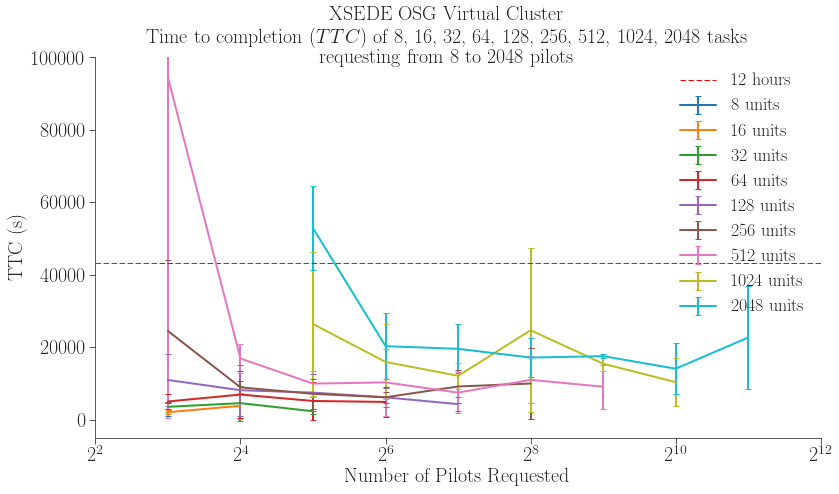

In [9]:
fig, ax = fig_setup()

colors=[tableau20[0] , tableau20[2] , tableau20[4] , tableau20[6] , 
        tableau20[8] , tableau20[10], tableau20[12], tableau20[14], 
        tableau20[16], tableau20[18], tableau20[20], tableau20[1] ,
        tableau20[3] , tableau20[5] , tableau20[7] , tableau20[9] ,
        tableau20[11], tableau20[13], tableau20[15], tableau20[17],
        tableau20[19]]

title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Time to completion ($TTC$) of 8, 16, 32, 64, 128, 256, 512, 1024, 2048 tasks\nrequesting from 8 to 2048 pilots'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)

nus = ttc['nunit_requested'].unique()
nus.sort()

for nu in nus:
    color = colors.pop(0)
    ttc.loc[ttc['nunit_requested']==nu].plot(
        x='npilot', 
        y='TTC_mean', 
        yerr='TTC_std', 
        label=str(int(nu))+' units',
        color=color,
        ax=ax)
    
plt.axhline(43200, color='r', linestyle='dashed', linewidth=1, label='12 hours')


ax.legend(loc=1)
ax.set_xscale('log', basex=2)
ax.set_xlim(2**2, 2**12)
ax.set_ylim(-5000, 100000)
ax.set_xlabel('Number of Pilots Requested')
ax.set_ylabel('TTC (s)')


### Distribution of task execution time ($T_x$) across all runs

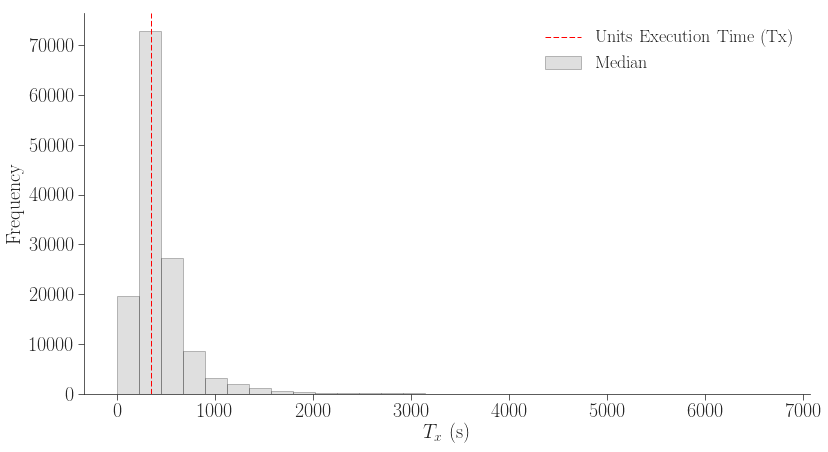

In [7]:
fig, ax = fig_setup()
title='XSEDE OSG Virtual Cluster\nDensity of Units Execution Time (Tx)\nNote: Tail truncated at 2000s.'

uosg[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.hist(
    ax=ax, 
    color='gray', 
    bins=30, 
    alpha = 0.25)#,
#     normed=True)
# units[['U_AGENT_EXECUTING']].dropna().reset_index(drop=True).plot.density(
#     ax=ax, 
#     color='black', 
#     title=title)

plt.axvline(uosg['U_AGENT_EXECUTING'].dropna().median(), color='r', linestyle='dashed', linewidth=1)

# ax.set_xlim(0, 2000)
ax.set_xlabel('$T_x$ (s)')
ax.legend(labels=['Units Execution Time (Tx)', 'Median'])

plt.savefig('figures/osg_dstrb_tx_all.pdf', dpi=600, bbox_inches='tight')

### Median task execution time ($T_x$) per host across all runs

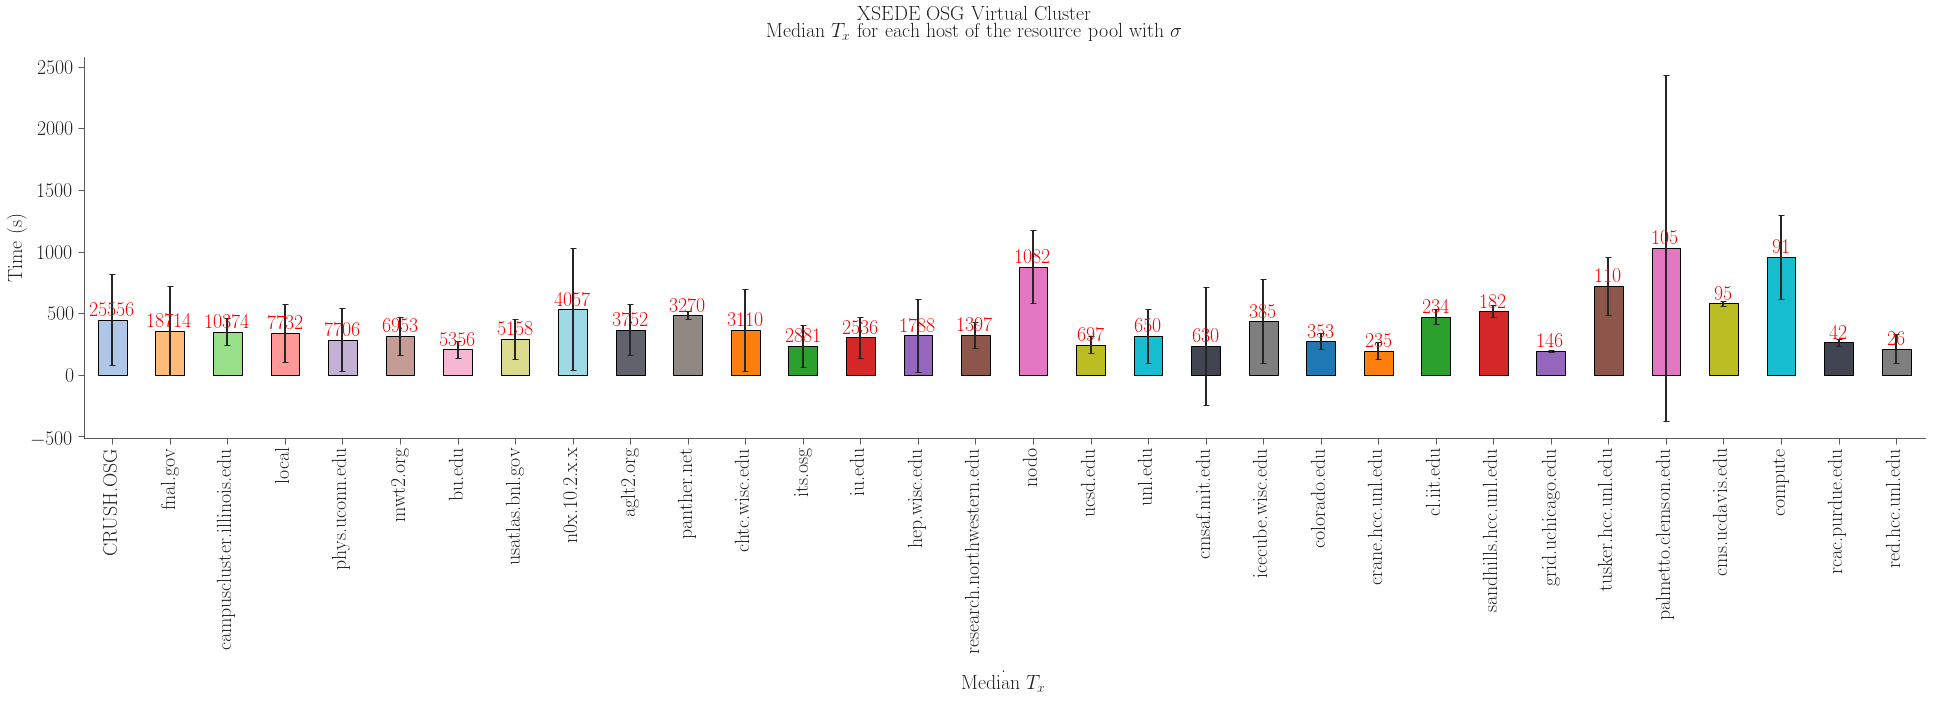

In [8]:
fig = plt.figure(figsize=(33,7))
ax = fig.add_subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
    
title_head = 'XSEDE OSG Virtual Cluster'
title_desc = 'Median $T_x$ for each host of the resource pool with $\sigma$'
title = '%s\n%s' % (title_head, title_desc)
fig.suptitle(title)


colors=[tableau20[1 ], tableau20[3 ], tableau20[5 ], tableau20[7] , tableau20[9 ], 
        tableau20[11], tableau20[13], tableau20[15], tableau20[17], tableau20[19], 
        tableau20[21], tableau20[2 ], tableau20[4 ], tableau20[6 ], tableau20[8 ], 
        tableau20[10], tableau20[12], tableau20[14], tableau20[16], tableau20[18],
        tableau20[20], tableau20[0 ], tableau20[2 ], tableau20[4] , tableau20[6 ], 
        tableau20[8 ], tableau20[10], tableau20[12], tableau20[14], tableau20[16], 
        tableau20[18], tableau20[20], tableau20[1 ], tableau20[3] , tableau20[5 ]]

index   = []
medians = []
stds    = []
ssize   = []
hosts   = uosg.loc[uosg['U_AGENT_EXECUTING'].notnull()]['hid'].dropna().unique()

# Derive medians, stds and sample size of tasks' Tx for each host
for host in hosts:
    sample = uosg[uosg.hid == host]['U_AGENT_EXECUTING'].dropna()
    index.append(host)
    medians.append(sample.median())
    stds.append(sample.std())
    ssize.append(len(sample.tolist()))

txs = pd.DataFrame({'medians': pd.Series(medians, index),
                    'stds'   : pd.Series(stds   , index),
                    'ssize'  : pd.Series(ssize  , index)})

txs = txs.sort_values(by='ssize', ascending=False)

# Plot bar diagram with sigma
txs.plot(
    y='medians', 
    yerr='stds',
    color=colors,
    ax=ax,
    kind='bar',
    legend=False)

# labels
rects = ax.patches
labels = [int(l) for l in txs.ssize.tolist()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 
            height, 
            label, 
            ha='center', 
            va='bottom', 
            color='red')

ax.set_ylabel('Time (s)')
ax.set_xlabel('.\nMedian $T_x$')

plt.savefig('figures/xsede_tx_per_host_bar.pdf', dpi=600, bbox_inches='tight')